# Loan Default Prediction - Part 09 - Gradient Boosted Decision Trees

This is an exploratory project for me to apply what I have learned in the Data Science and Machine Learning courses that I took this year. The data is from a Kaggle competition [Loan Default Prediction](https://www.kaggle.com/c/loan-default-prediction). 

This is Part 09 of the project: Gradient Boosted Decision Trees.

In this part, I will be using the [XGBoost](https://github.com/dmlc/xgboost) eXtreme Gradient Boosting library as my model. XGBoost has [its own set of APIs](https://xgboost.readthedocs.io/en/latest/python/python_api.html) as well as [another set compatible with __sklearn__](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn). I have been using __sklearn__ a lot in the previous parts, so I decide to use the XGBoost native APIs here.

I will first load the data.

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import time
import project_utils as utils

In [2]:
# Load the training data (imputed but not normalized) from the CSV file
df, X, y = utils.load_csv('train_v2_preprocessed.csv')

# Separate training and validation sets
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
X_train, y_train, X_valid, y_valid = utils.split_data(kf, X, y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f1_0 to loss
dtypes: float64(1789)
memory usage: 1.4 GB


## XGBoost Model

To use the XGBoost native APIs, I need to load the data into the XGBoost DMatrix data structure.

In [3]:
import xgboost as xgb

# Load the data into the XGBoost data structure
d_train = xgb.DMatrix(X_train.values, y_train.values)
d_valid = xgb.DMatrix(X_valid.values, y_valid.values)

Next, we define essential [parameters](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md) for the model and then train the model.

In [4]:
# Define parameters

param = {'eta': 0.1, 'objective': 'binary:logistic', 'eval_metric': 'auc'}
num_boost_round = 5

In [5]:
# Train the model

def train_model(param, d_train, num_boost_round):
    start = time.time()
    bst = xgb.train(param, d_train, num_boost_round)
    end = time.time()
    fit_time = end - start
    print('Time elapsed (Training): %.4f s' % fit_time)

    return bst, fit_time

bst, fit_time = train_model(param, d_train, num_boost_round)

Time elapsed (Training): 5.2253 s


Accuracy Score (Training): 0.906620
ROCAUC Score (Training): 0.723478
PRAUC Score (Training): 0.153205
Accuracy Score (Validation): 0.912064
ROCAUC Score (Validation): 0.685717
PRAUC Score (Validation): 0.072483
Time elapsed (Evaluation): 0.3609 s


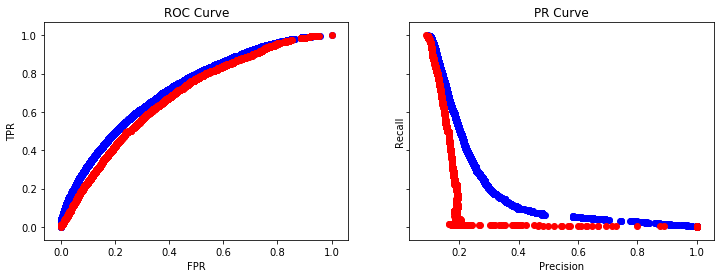

In [6]:
# Evaluate the model

import matplotlib.pyplot as plt
from sklearn import metrics

def evaluate(bst, d_train, y_train, d_valid, y_valid, plot=True):
    # Plotting ROCAUC and PRAUC
    f, (plt1, plt2) = plt.subplots(1, 2, sharey=True, figsize=(12, 4))        
    plt1.set_title('ROC Curve')
    plt1.set_xlabel('FPR')
    plt1.set_ylabel('TPR')
    plt2.set_title('PR Curve')
    plt2.set_xlabel('Precision')
    plt2.set_ylabel('Recall')
    
    start = time.time()

    # Training set
    y_train_predicted = bst.predict(d_train)
    fpr, tpr, thresholds = metrics.roc_curve(y_train.values, y_train_predicted)
    precision, recall, thresholds = metrics.precision_recall_curve(y_train.values, y_train_predicted)
    plt1.scatter(fpr, tpr, color='b')    
    plt2.scatter(precision, recall,color='b')
    print('Accuracy Score (Training): %f' % metrics.accuracy_score(y_train.values, [round(value) for value in y_train_predicted]))
    print('ROCAUC Score (Training): %f' % metrics.roc_auc_score(y_train.values, y_train_predicted))
    print('PRAUC Score (Training): %f' % metrics.auc(precision, recall, reorder=True))

    # Validation set
    y_valid_predicted = bst.predict(d_valid)
    fpr, tpr, thresholds = metrics.roc_curve(y_valid.values, y_valid_predicted)
    precision, recall, thresholds = metrics.precision_recall_curve(y_valid.values, y_valid_predicted)
    plt1.scatter(fpr, tpr, color='r')    
    plt2.scatter(precision, recall,color='r')
    acc_score = metrics.accuracy_score(y_valid.values, [round(value) for value in y_valid_predicted])
    print('Accuracy Score (Validation): %f' % acc_score)
    rocauc_score = metrics.roc_auc_score(y_valid.values, y_valid_predicted)
    print('ROCAUC Score (Validation): %f' % rocauc_score)
    prauc_score = metrics.auc(precision, recall, reorder=True)
    print('PRAUC Score (Validation): %f' % prauc_score)
    
    end = time.time()
    eval_time = end - start
    print('Time elapsed (Evaluation): %.4f s' % eval_time)

    if plot:
            plt.show()
    plt.close()

    return acc_score, rocauc_score, prauc_score, eval_time
    
acc_score, rocauc_score, prauc_score, eval_time = evaluate(bst, d_train, y_train, d_valid, y_valid)

## Class Weights

Adding class weights and train another model.

Time elapsed (Training): 4.2146 s
Accuracy Score (Training): 0.603537
ROCAUC Score (Training): 0.735041
PRAUC Score (Training): 0.148755
Accuracy Score (Validation): 0.588718
ROCAUC Score (Validation): 0.681429
PRAUC Score (Validation): 0.183893
Time elapsed (Evaluation): 0.3709 s


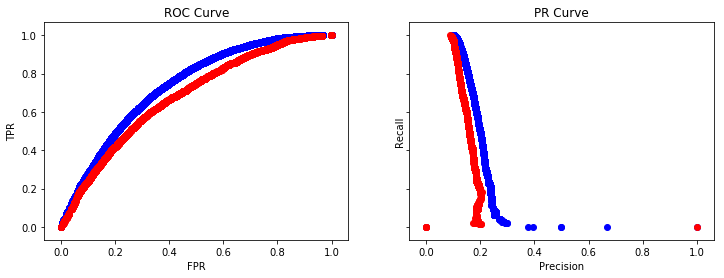

In [7]:
param.update({'scale_pos_weight': 10.})
bst, fit_time = train_model(param, d_train, num_boost_round)
acc_score, rocauc_score, prauc_score, eval_time = evaluate(bst, d_train, y_train, d_valid, y_valid)

Accuracy dropped, ROCAUC dropped slightly from 0.686 to 0.681, but PRAUC improved from 0.072 to 0.184.

## Normalized Data

I'll also try using normalized data to train two models, one with class weights and one without.

In [8]:
# Load the training data (imputed and normalized) from the CSV file
df, X, y = utils.load_csv('train_v2_preprocessed_normalized.csv')

# Separate training and validation sets
X_train, y_train, X_valid, y_valid = utils.split_data(kf, X, y)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105471 entries, 0 to 105470
Columns: 1789 entries, f3 to loss
dtypes: float64(1789)
memory usage: 1.4 GB


In [9]:
# Load the data into the XGBoost data structure

d_train = xgb.DMatrix(X_train.values, y_train.values)
d_valid = xgb.DMatrix(X_valid.values, y_valid.values)

In [10]:
# Define parameters

param = {'eta': 0.1, 'objective': 'binary:logistic', 'eval_metric': 'auc'}
num_boost_round = 5

Time elapsed (Training): 5.1933 s
Accuracy Score (Training): 0.906620
ROCAUC Score (Training): 0.722820
PRAUC Score (Training): 0.152421
Accuracy Score (Validation): 0.912064
ROCAUC Score (Validation): 0.685919
PRAUC Score (Validation): 0.072673
Time elapsed (Evaluation): 0.3109 s


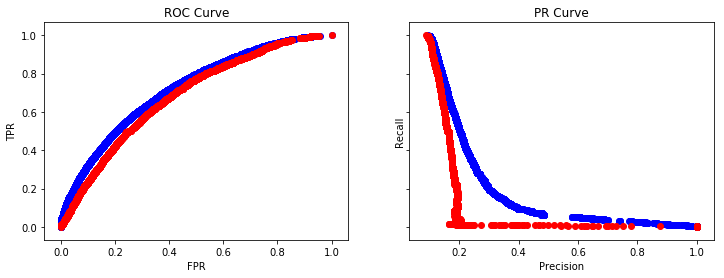

In [11]:
# Train and evaluate the model

bst, fit_time = train_model(param, d_train, num_boost_round)
acc_score, rocauc_score, prauc_score, eval_time = evaluate(bst, d_train, y_train, d_valid, y_valid)

Time elapsed (Training): 4.4446 s
Accuracy Score (Training): 0.603537
ROCAUC Score (Training): 0.735041
PRAUC Score (Training): 0.148755
Accuracy Score (Validation): 0.588718
ROCAUC Score (Validation): 0.681403
PRAUC Score (Validation): 0.183890
Time elapsed (Evaluation): 0.3689 s


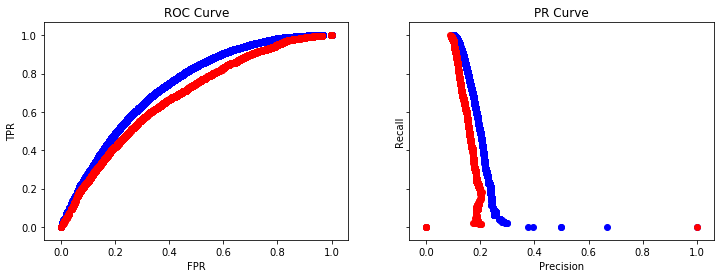

In [12]:
# Adding class weights

param.update({'scale_pos_weight': 10.})
bst, fit_time = train_model(param, d_train, num_boost_round)
acc_score, rocauc_score, prauc_score, eval_time = evaluate(bst, d_train, y_train, d_valid, y_valid)

The scores are almost exactly the same, which indicates that XGBoost doesn't require data to be normalized either.

## Tree Visualization

XGBoost provides APIs to easily visualize the trees. I will take the last model I trained and plot it. There are a total of __num_boost_round__=5 trees. Because the details are too small to read clearly, I also export them into PDF files.

In [13]:
from xgboost import plot_tree

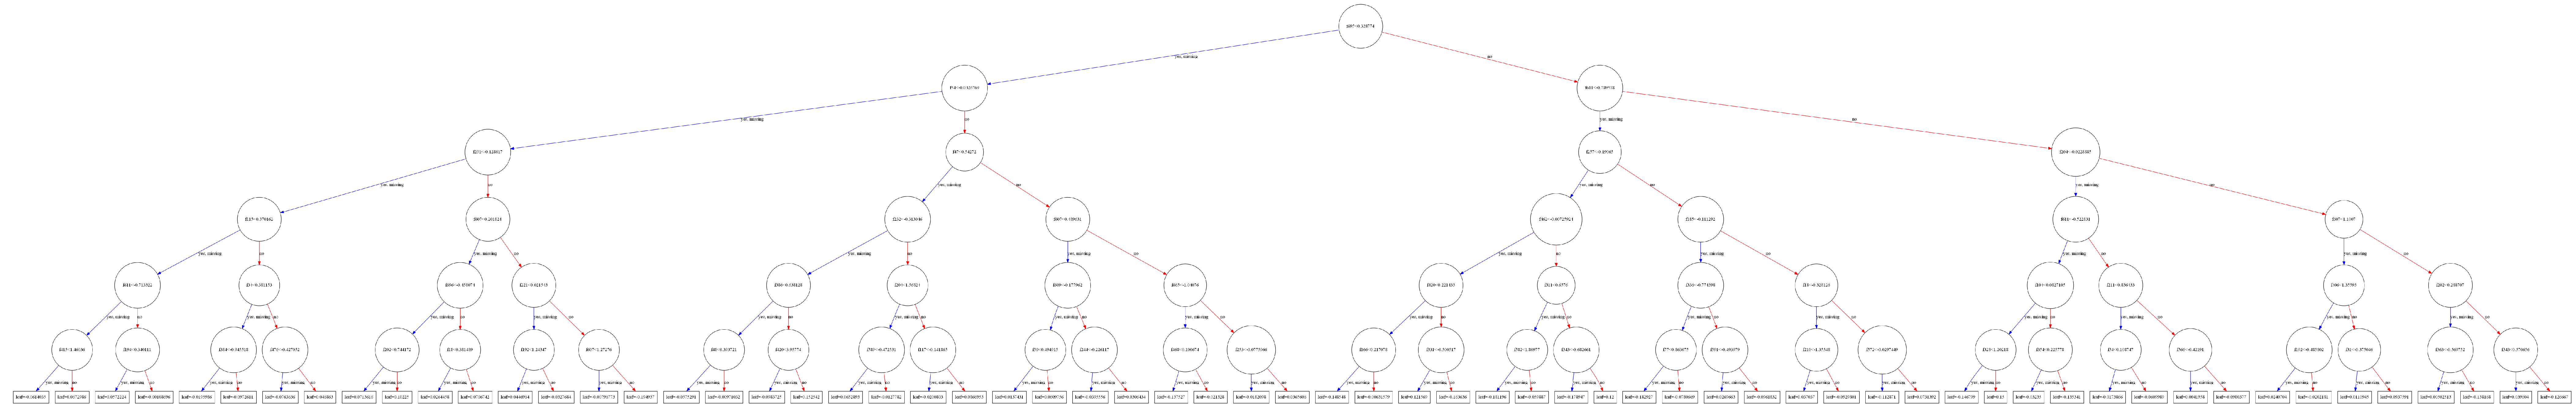

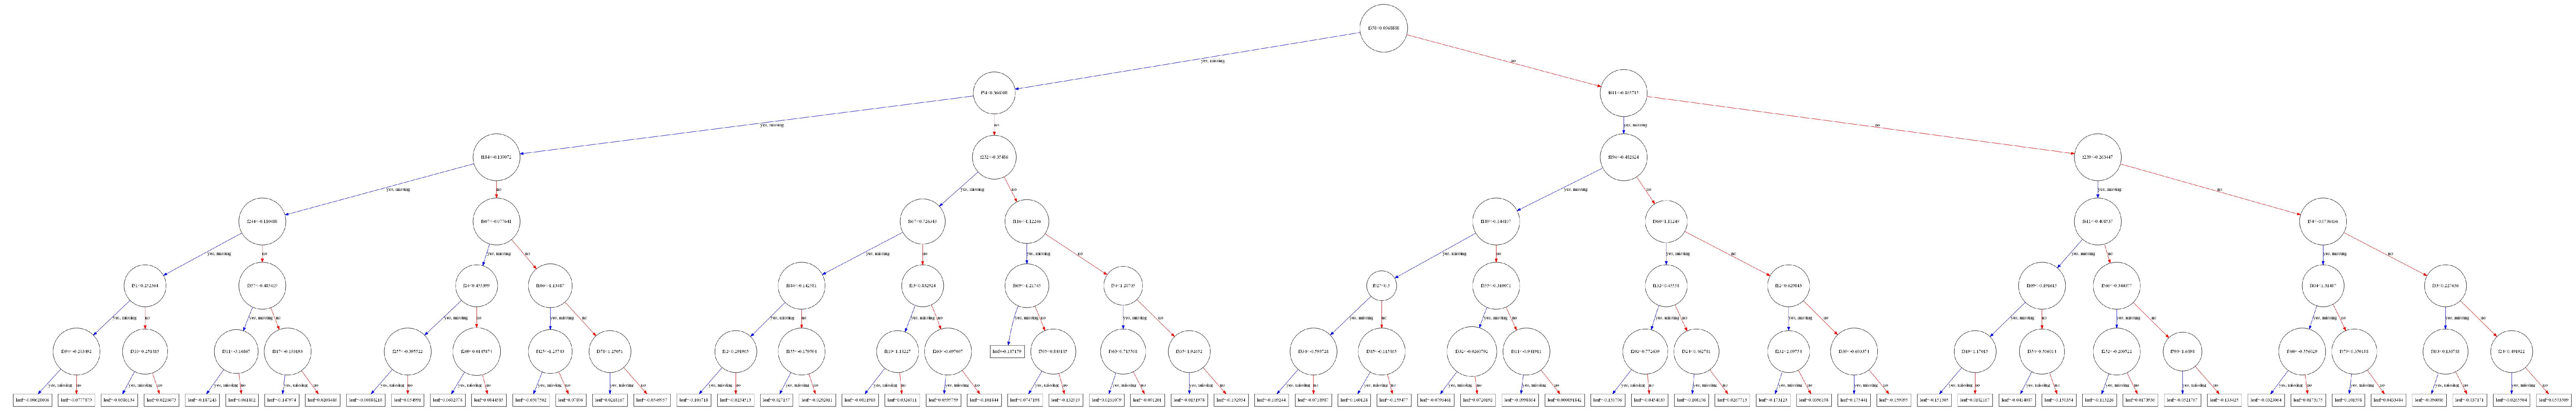

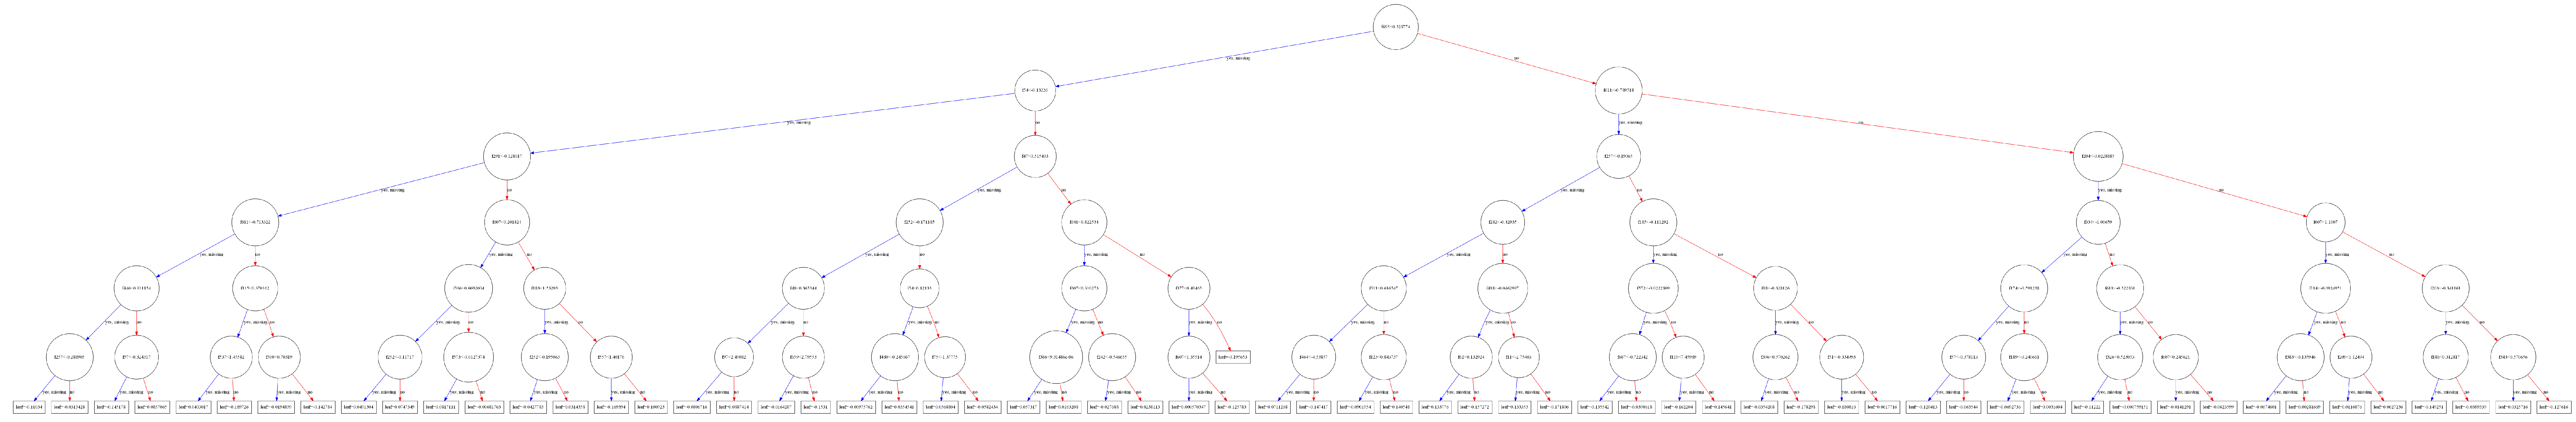

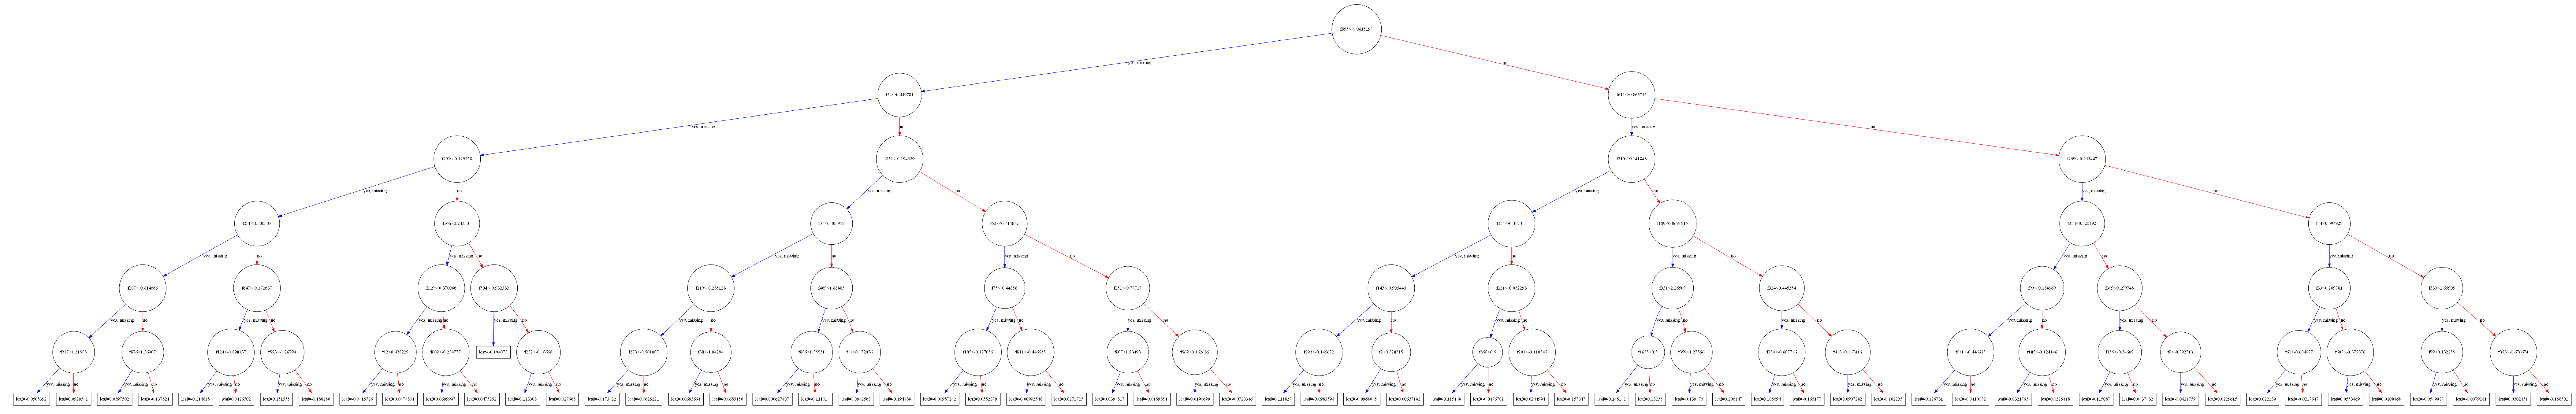

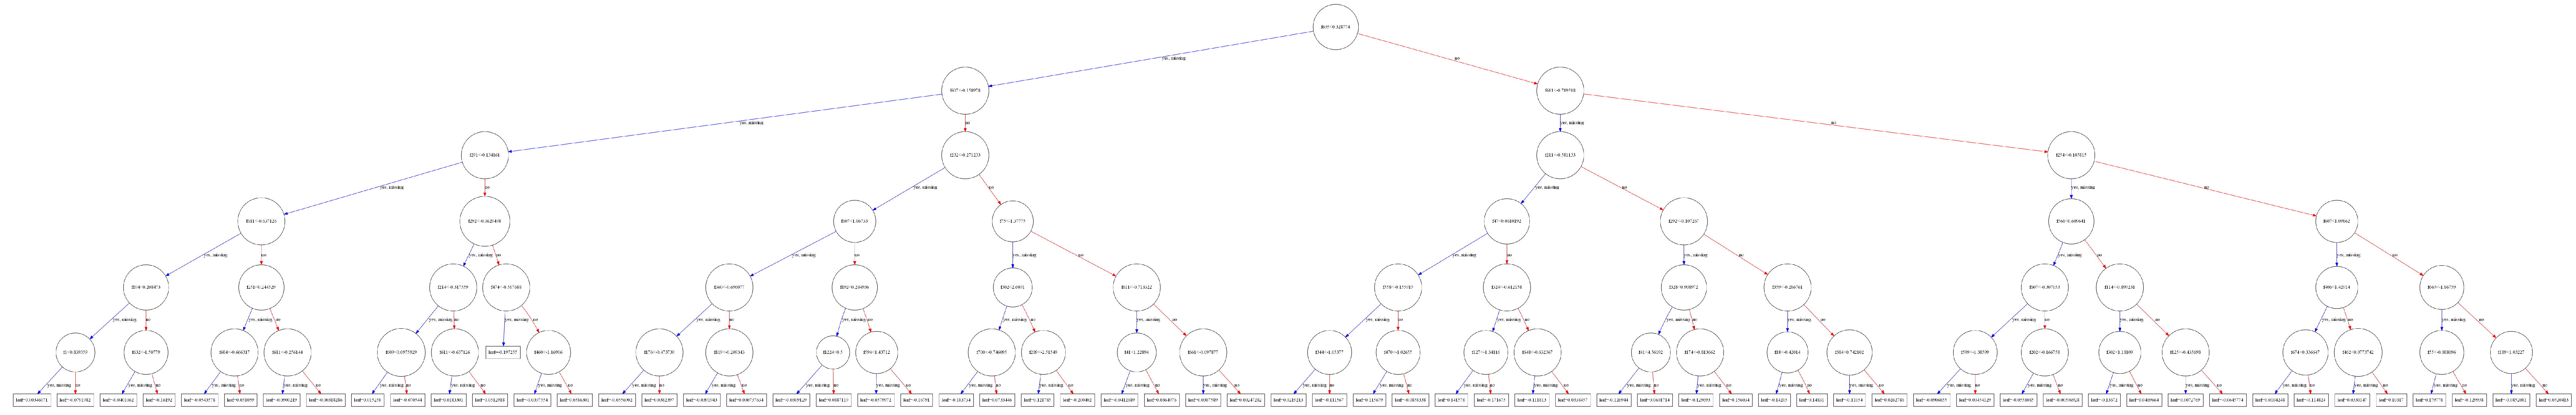

In [14]:
for i in range(num_boost_round):
    plot_tree(bst, num_trees=i)
    fig = plt.gcf()
    fig.set_size_inches(150, 100)
    filename = 'xgboost-visualization-%d.pdf' % (i + 1)
    fig.savefig(filename, dpi=300, format='pdf')
    plt.show()